In [356]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import os
from sklearn.metrics import mean_squared_error

In [357]:
channels = ['Fp1', 'Fz', 'F3', 'F7', 'F9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7'
            , 'P9', 'O1', 'Oz', 'O2', 'P10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'C4', 'Cz'
            , 'FC2', 'FC6', 'F10', 'F8', 'F4', 'Fp2','AUX_1', 'ACC_X', 'ACC_Y', 'ACC_Z']
removed_channels = ['Fp1', 'F8', 'F7', 'Fp2', 'F3', 'F4']
# TODO ADD AUX WHEN CONNECTED
eye_data_names = ['x', 'y', 'z', 'left_blink', 'right_blink', 'both_blink', 'left_openness', 'right_openness']

columns =  eye_data_names + channels

#data, header = pyxdf.load_xdf('data/LSLDataV2/LSLDataLeftFourTimes2/eeg-and-eyetracking.xdf')


In [358]:
def get_time_stamps(stamps: list):
    start = []
    end = []
    more_than_one = False

    for i in range(len(stamps)):
        if i == (len(stamps)-1):
            if(stamps[i-1] == (stamps[i] - 1)):
                end.append(stamps[i])
            break

        if(stamps[i] == (stamps[i+1] - 1)):
            if not more_than_one:
                start.append(stamps[i])
            more_than_one = True
            continue
        else:
            if more_than_one:
                end.append(stamps[i])
                more_than_one = False

    return start, end

In [359]:
def plot_eeg_blink_single_norm(df,df_ts, start, end,column,rang = 50, scale=1, flip = False):
    plt.figure(figsize=(10,6))
    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(df_ts['time'][start], color='green', label = "Blink start - TobiiXR")  # y = 0
    axis.axvline(df_ts['time'][end], color='red', label = "Blink End - TobiiXR")
    df_norm = (df[column].abs() / df[column].abs().max())
    plus = -df_norm[start - rang]
    axis.plot(df_ts['time'][start-rang:end+rang], (df_norm + plus) *(-1 if flip else 1) *scale, label = "EMG")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['left_openness'] / df['left_openness'].abs().max())
               *(-1)+ 1, color='orange', label = "Eye openness - SRanipal")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['right_openness'] / df['right_openness'].abs().max())
               *(-1)+ 1, color='violet', label = "Eye openness right - SRanipal")
    axis.set_xlabel("Time normalized (seconds)")
    axis.set_ylabel("Amplitude ")
    axis.set_title(column)
    plt.legend()
    plt.show()

def plot_eeg_blink_single(df,df_ts, start, end,column,rang = 50):
    plt.figure(figsize=(10,6))
    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(df_ts['time'][start], color='green', label = "Blink start - TobiiXR")  # y = 0
    axis.axvline(df_ts['time'][end], color='red', label = "Blink End - TobiiXR")

    axis.plot(df_ts['time'][start-rang:end+rang], df[column], label = "EMG")
    axis.plot(df_ts['time'][start-rang:end+rang], df['left_openness'], color='orange', label = "Eye openness left - SRanipal")
    axis.plot(df_ts['time'][start-rang:end+rang], df['right_openness'], color='violet', label = "Eye openness right - SRanipal")
    axis.set_title(column)
    plt.legend()
    plt.show()

In [360]:

def init_data(data, shift = 0):
    for s in data:
        stream = s
        y = stream['time_series']
        df_stream = pd.DataFrame(y)
        df_stream_ts = pd.DataFrame(stream['time_stamps'])
        df_stream_ts.columns = ['time']
        df_stream.columns = columns
        df_stream['AUX_1'] = df_stream['AUX_1']+ 1000000
        if shift != 0:
            df_stream['AUX_1'] = df_stream['AUX_1'].shift(shift)
        return stream, df_stream, df_stream_ts

#stream, df_stream, df_stream_ts = init_data(data)
def get_blinks_in_df(df):
    left_blinks = df.index[(df['left_blink'] >= 1) & (df['right_blink'] != 1)].tolist()
    right_blinks = df.index[(df['right_blink'] >= 1) & (df['left_blink'] != 1)].tolist()
    both_blink = df.index[df['both_blink'] == 1].tolist()
    return left_blinks,right_blinks, both_blink

#left_blinks, right_blinks, both_blink = get_blinks_in_df(df_stream)

In [361]:
#avg_time = np.diff(df_stream_ts.to_numpy().flatten()).tolist()

In [362]:
#start, end = get_time_stamps(left_blinks)


In [363]:
def find_close_values_mean(values,y, tolerance):
    # Sort the input list for easier comparison of adjacent elements
    values.sort()
    peak = values[np.argmax([y[i] for i in values])]
    # Iterate through the sorted list and compare adjacent elements
    for i in range(len(values) - 1):
        if abs(values[i] - peak) <= tolerance and values[i] != peak:
            # If the two values are close, return their mean
            return (values[i] + values[i + 1]) / 2

    # If no close values are found, return None
    return peak


def get_peaks(df, start, end, column, rang=50, scale=1, flip=False):
    df = df[start - rang:end + rang]
    df_norm = (df[column].abs() / df[column].abs().max())
    plus = -df_norm[start - rang]
    y = ((df_norm + plus) *(-1 if flip else 1) *scale).tolist()
    peaks, _ = signal.find_peaks(y)
    peaks = [peak for peak in peaks]
    if len(peaks) == 0:
        #print(df)
        return 0

    peak = find_close_values_mean(peaks, y, 20)+ start - rang
    return  peak



In [364]:


def find_shift(start, peaks):
    differences_start = []
    differences_end = []
    for i in range(len(peaks)):
        diff = start[i]-peaks[i]
        if diff < -999:
            diff = None
        differences_start.append(diff)
    return differences_start

def plot_table(df):
    #make this example reproducible

    #define figure and axes
    fig, ax = plt.subplots()
    #hide the axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    #create data

    #create table
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')
    table.scale(2.5, 2.5)
    table.set_fontsize(30)
    plt.show()

In [365]:

def run_files(paths, path='data/LSLData120hz/',file = 'dejittered-fir-1to28-eeg-and-dejittered-eyetracking.xdf', rang=50, both = True, plot = False, shift_init=0):
    peak_info = []
    avg_time = []
    for (index,y) in enumerate(paths):

        data, header = pyxdf.load_xdf(path+str(y)+'/' + file)
        stream, df_stream, df_stream_ts = init_data(data,shift_init)
        left_blinks, right_blinks, both_blink = get_blinks_in_df(df_stream)
        start, end = get_time_stamps(both_blink)
        avg_time.append(np.diff(df_stream_ts.to_numpy().flatten()).tolist())
        peaks = []
        for i in range(len(start)):
            if i >= 10:
                continue
            peaks.append(get_peaks(df_stream, start[i], end[i], chosen_channel, rang=rang, scale=5, flip=both))

        shift = find_shift(start, peaks)
        peak_info.append(shift)

    n = len(max(peak_info, key=len))
    t = [x + [None]*(n-len(x)) for x in peak_info]
    numpy_array_peak_info = np.array(t)
    df_peak = pd.DataFrame(numpy_array_peak_info)
    df_peak = df_peak.set_index([paths])
    df_peak['time between index (s)'] = [i[0] for i in avg_time]
    df_peak['Sum (indexes)'] = df_peak.sum(axis=1)
    df_peak['Avg (indexes)'] = round(df_peak.loc[:, 0:9].mean(axis=1),3)
    df_peak['Avg time (ms)'] = round(df_peak['Avg (indexes)']*df_peak['time between index (s)'],5)*1000
    if plot:
        plot_table(df_peak)
    return df_peak



In [366]:
['zerophase-dejittered-iir-4order-0.75to5-eeg-and-dejittered-eyetracking.xdf', 'dejittered-iir-3order-0.75to5-eeg-and-dejittered-eyetracking.xdf']
path = "./data/LSLDataFastBlinksSamletOnline/"
file = "dejittered-iir-3order-0.75to5-eeg-and-dejittered-eyetracking.xdf"
paths = [name for name in os.listdir(path)]
both = [name for name in paths if "LSLDataV4_13" not in name]
flip = True
chosen_channel = 'AUX_1'

df_both = run_files(both, both=flip, file = file, plot=False, path = path)
#df_both= df_both.drop(['LSLDataV4_8', 'LSLDataV4_6', 'LSLDataV4_1'])
#df_both = df_both.drop(df_both.columns[[1]], inplace=True, axis=1)
display(df_both)


,0,1,2,3,4,5,6,7,8,9,time between index (s),Sum (indexes),Avg (indexes),Avg time (ms)
LSLData_fast_blinksV2_1,-9.0,-8.0,-10.0,-9.0,-9.0,-9.0,-11.0,-10.0,-10.0,-11.0,0.008333,-95.991667,-9.60,-80.00
LSLData_fast_blinksV2_10,-10.0,-9.0,-8.0,-10.0,-8.0,-9.0,-11.0,-10.0,-9.0,-10.0,0.008333,-93.991667,-9.40,-78.33
LSLData_fast_blinksV2_11,-8.0,-7.0,-8.0,-9.0,-9.0,-8.0,-10.0,-11.0,-9.0,-8.0,0.008333,-86.991667,-8.70,-72.50
LSLData_fast_blinksV2_13,-8.0,-11.0,-8.0,-10.0,-9.0,-7.0,-10.0,-9.0,-10.0,-9.0,0.008333,-90.991667,-9.10,-75.83
LSLData_fast_blinksV2_14,-12.0,-12.0,-10.0,-10.0,-9.0,-9.0,-10.0,-10.0,-10.0,-8.0,0.008333,-99.991667,-10.00,-83.33
LSLData_fast_blinksV2_15,-8.0,-10.0,-11.0,-11.0,-9.0,-10.0,-9.0,-12.0,-10.0,-11.0,0.008333,-100.991667,-10.10,-84.17
LSLData_fast_blinksV2_16,-11.0,-11.0,-12.0,-12.0,-11.0,-10.0,-10.0,-11.0,-9.0,-9.0,0.008333,-105.991667,-10.60,-88.33
LSLData_fast_blinksV2_17,-11.0,-12.0,-13.0,-13.0,-11.0,-10.0,-11.0,-10.0,-12.0,-12.0,0.008333,-114.991667,-11.50,-95.83
LSLData_fast_blinksV2_18,-9.0,-12.0,-10.0,-9.0,-10.0,-10.0,-12.0,-11.0,-11.0,-13.0,0.008333,-106.991667,-10.70,-89.17
LSLData_fast_blinksV2_19,-10.0,-10.0,-9.0,-12.0,-13.0,-11.0,-10.0,-11.0,-11.0,-10.0,0.008333,-106.991667,-10.70,-89.17


In [367]:
def get_offset(df):
    avg_offset = df['Avg time (ms)'].sum()/df.shape[0]
    avg_offset_index = df['Avg (indexes)'].sum()/df.shape[0]
    #print(avg_offset_index)
    return avg_offset, avg_offset_index


In [368]:
print("(ms, Number of indexes to shift) ---- Both")
print(get_offset(df_both))
df_both_shift = run_files(both, both=flip ,file=file, plot=False,path = path,rang=20, shift_init=round(get_offset(df_both)[1]))
#df_both_shift = df_both_shift.drop(['LSLDataV4_8', 'LSLDataV4_6', 'LSLDataV4_1'])
#df_both_shift.loc['Average']= df_both_shift.sum(numeric_only=True, axis=0)/df_both_shift.shape[0]
display(df_both_shift)


print(get_offset(df_both_shift))

(ms, Number of indexes to shift) ---- Both
(-85.68884615384614, -10.282692307692306)


,0,1,2,3,4,5,6,7,8,9,time between index (s),Sum (indexes),Avg (indexes),Avg time (ms)
LSLData_fast_blinksV2_1,1.0,2.0,0.0,1.0,1.0,1.0,-1.0,0.0,0.0,-1.0,0.008333,4.008333,0.40,3.33
LSLData_fast_blinksV2_10,0.0,1.0,2.0,0.0,2.0,1.0,-1.0,0.0,1.0,0.0,0.008333,6.008333,0.60,5.00
LSLData_fast_blinksV2_11,2.0,3.0,2.0,1.0,1.0,2.0,0.0,-1.0,1.0,2.0,0.008333,13.008333,1.30,10.83
LSLData_fast_blinksV2_13,2.0,-1.0,2.0,0.0,1.0,3.0,0.0,1.0,0.0,1.0,0.008333,9.008333,0.90,7.50
LSLData_fast_blinksV2_14,-2.0,-2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.008333,0.008333,0.00,0.00
LSLData_fast_blinksV2_15,2.0,0.0,-1.0,-1.0,1.0,0.0,1.0,-2.0,0.0,-1.0,0.008333,-0.991667,-0.10,-0.83
LSLData_fast_blinksV2_16,-1.0,-1.0,-2.0,-2.0,-1.0,0.0,0.0,-1.0,1.0,1.0,0.008333,-5.991667,-0.60,-5.00
LSLData_fast_blinksV2_17,-1.0,-2.0,-3.0,-3.0,-1.0,0.0,-1.0,0.0,-2.0,-2.0,0.008333,-14.991667,-1.50,-12.50
LSLData_fast_blinksV2_18,1.0,-2.0,0.0,1.0,0.0,0.0,-2.0,-1.0,-1.0,-3.0,0.008333,-6.991667,-0.70,-5.83
LSLData_fast_blinksV2_19,0.0,0.0,1.0,-2.0,-3.0,-1.0,0.0,-1.0,-1.0,0.0,0.008333,-6.991667,-0.70,-5.83


(-2.6442307692307687, -0.31730769230769224)


In [369]:
import statistics
from scipy.stats import sem

standard_de_both = statistics.stdev(df_both['Avg time (ms)'])
se_both = sem(df_both['Avg time (ms)'])
print("Standard devation")
print("Both: " + str(standard_de_both))

print("-------- SE ----------")
print("Both: " + str(se_both))

Standard devation
Both: 9.809486154502927
-------- SE ----------
Both: 1.923798512312641


In [370]:
standard_de_both_shift = statistics.stdev(df_both_shift['Avg time (ms)'])
se_both_shift = sem(df_both_shift['Avg time (ms)'])
print("Standard devation - After shift")
print("Both: " + str(standard_de_both_shift))
print("-------- SE - After shift ----------")
print("Both: " + str(se_both_shift))

Standard devation - After shift
Both: 9.082607631325674
-------- SE - After shift ----------
Both: 1.7812459056321674


[-0.19169999999999998, -0.1833, -0.125, -0.1167, -0.1125, -0.1, -0.0917, -0.0917, -0.075, -0.0667, -0.0583, -0.0583, -0.05, -0.025, -0.0083, 0.0, 0.016700000000000003, 0.016700000000000003, 0.025, 0.0333, 0.05, 0.075, 0.0833, 0.0917, 0.10830000000000001, 0.16670000000000001]


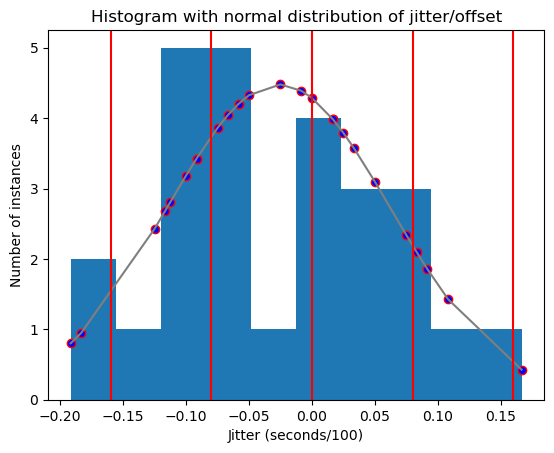

In [371]:
from scipy.stats import norm
# Plot between -10 and 10 with .001 steps.
x_axis = sorted((df_both_shift['Avg time (ms)']/100).tolist())
print(x_axis)

plt.hist(x_axis)
for i in range(len(x_axis)):
    plt.plot(x_axis[i],  norm.pdf(x_axis,np.mean(x_axis),np.std(x_axis))[i], marker="o", markersize=6, markeredgecolor="red", markerfacecolor="blue")
plt.plot(x_axis, norm.pdf(x_axis,np.mean(x_axis),np.std(x_axis)))
plt.axvline(x=0, ymax=6, ymin=0, color='r', linestyle='-')
plt.axvline(x=-0.08, ymax=6, ymin=0, color='r', linestyle='-')
plt.axvline(x=-0.08*2, ymax=6, ymin=0, color='r', linestyle='-')
plt.axvline(x=0.08, ymax=6, ymin=0, color='r', linestyle='-')
plt.axvline(x=0.08*2, ymax=6, ymin=0, color='r', linestyle='-')
plt.title("Histogram with normal distribution of jitter/offset")
plt.xlabel("Jitter (seconds/100)")
plt.ylabel("Number of instances")
plt.show()

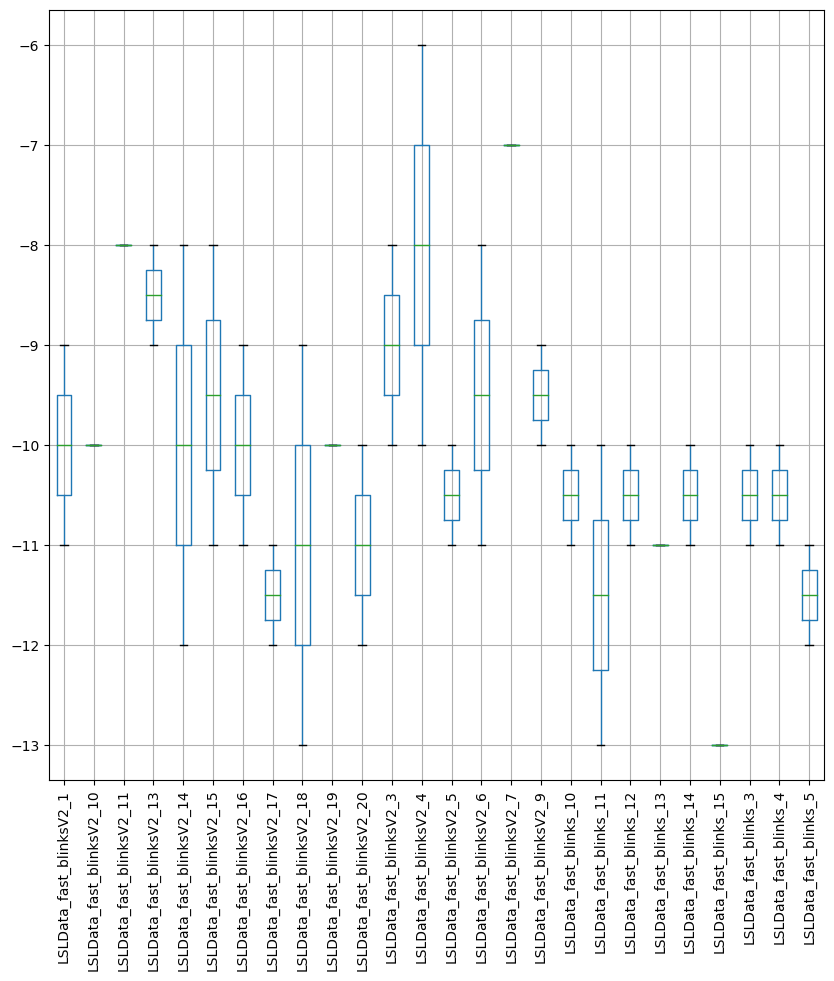

In [372]:

boxplot = df_both.iloc[:, [0, 9]].T.boxplot(figsize=(10,10), rot=90)

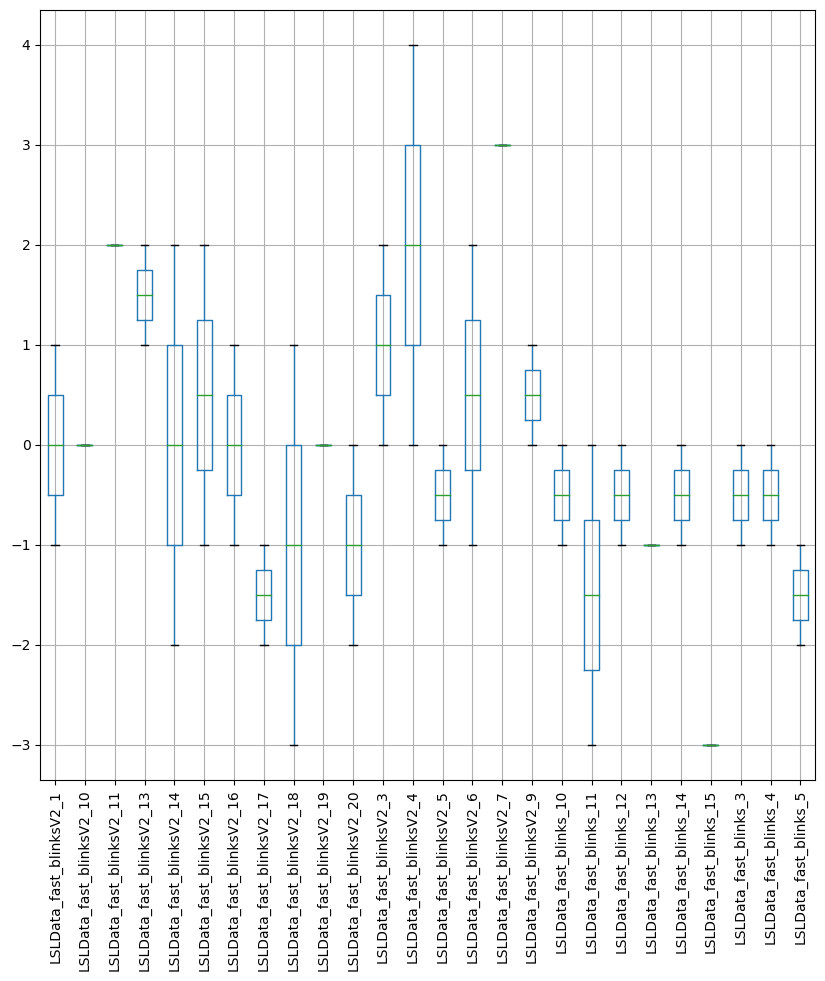

In [373]:
boxplot = df_both_shift.iloc[:, [0, 9]].T.boxplot(figsize=(10,10), rot=90)